In [33]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from IPython.display import display, HTML

%matplotlib inline
# from moses personal depence code:
from importance_and_dependence import (MyRandomForestClassifier,
                                       MyRandomForestRegressor,
                                       my_oob_permutation_importance,
                                       partial_dependence,
                                       partial_dependence_2d)

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_auc_score

df_train = pd.read_csv('data/churn_train.csv', parse_dates=['last_trip_date', 'signup_date'])
df_test = pd.read_csv('data/churn_test.csv', parse_dates=['last_trip_date', 'signup_date'])
df_tot = pd.read_csv('data/churn.csv', parse_dates=['last_trip_date', 'signup_date'])

cutoff = cutoff = df_tot.last_trip_date.max() - pd.to_timedelta(30,'D')
def prepare_data(df):
    missing = df.isna().sum()
    clean_labels = missing[missing == 0].index
    dirtyl_labels = missing[missing > 0].index
    new_df = df[clean_labels]
    
    to_keep = ['avg_dist', 'avg_surge', 'surge_pct', 'weekday_pct']
    filtered_df = new_df.loc[:, to_keep]
    
    y = df.last_trip_date <= cutoff
    return filtered_df, y

# X, y train/test variables:
train_X, train_y = prepare_data(df_train)
test_X, test_y = prepare_data(df_test)

# run model
rf = RandomForestClassifier()
model = rf.fit(train_X, train_y)
yhat = model.predict(test_X)

# Precision, Recall, Accuracy
def ezprint_cmatrix(ytrue, yhat):
    print("Precision: ", precision_score(ytrue, yhat))
    print("Recall: ", recall_score(ytrue, yhat))
    print("Accuracy score", accuracy_score(ytrue, yhat))

ezprint_cmatrix(test_y, yhat)

# ezprint_cmatrix(test_y, np.ones((len(yhat), 1)))

# Specificity
def specificity_score(y_true, y_pred):
    TN = len(y_true[y_true == y_pred and y_true == False])
    FP = len(y_true[y_true != y_pred and y_true == False])
    return TN / (TN + FP)

# Andrew added
df_train = prepare_data(df_train)[0]
df_test = prepare_data(df_test)[0]

Precision:  0.7525521865
Recall:  0.780869565217
Accuracy score 0.699


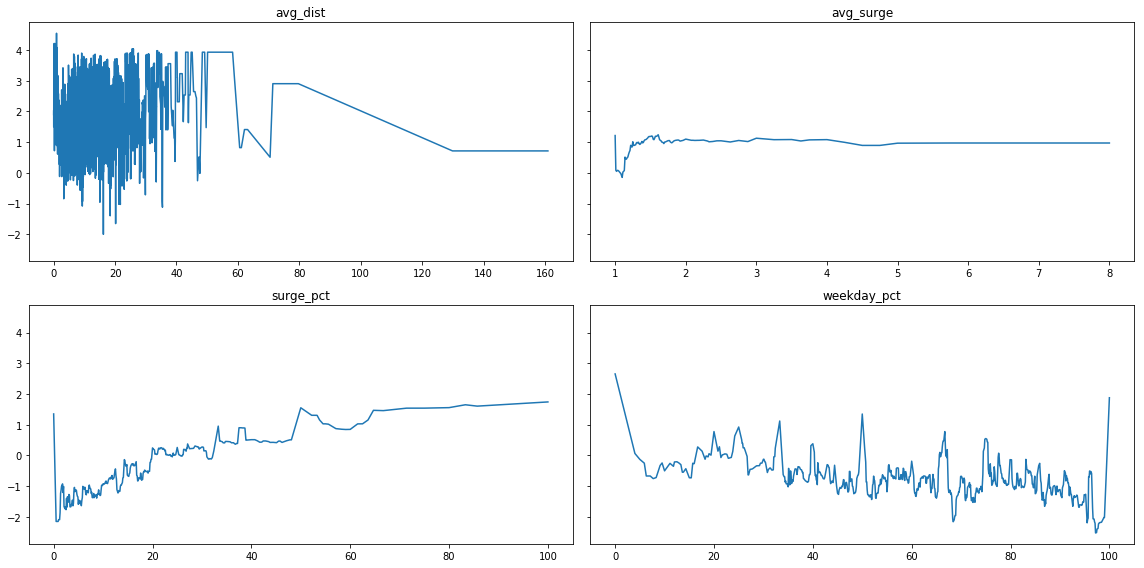

In [40]:
feature_indices = [0,1,2,3]

fig, axes = plt.subplots(2,2, figsize=(16,8), sharey=True, )

for ax, feat_ind in zip(axes.flatten(), feature_indices):
    xx, pdp = partial_dependence(model, train_X.values, feat_ind)
    ax.plot(xx, pdp)
    ax.set_title(df_train.columns[feat_ind])
plt.tight_layout()